In [35]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt 
import os # required to access the data path

%matplotlib inline

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
DATA_PATH = '/content/drive/MyDrive/Kim/mnist_mine.mat' 

In [38]:
data = loadmat(DATA_PATH)
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'testX', 'testY', 'trainY', 'trainX'])

In [39]:
X_train = loadmat(DATA_PATH)['trainX']
y_train = loadmat(DATA_PATH)['trainY']

X_test = loadmat(DATA_PATH)['testX']
y_test = loadmat(DATA_PATH)['testY']

In [40]:
X_train.shape, y_train.shape

((60000, 784), (1, 60000))

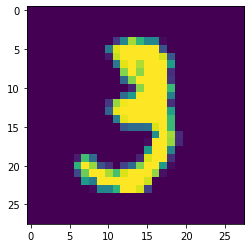

In [41]:
m = X_train.shape[0]
plt.imshow(X_train[10].reshape(28, 28))

In [42]:
# reshape image features before feeding it to the CNN
# also normalize the image pixels
X_train = X_train.reshape(m, 28, 28, 1).astype('float32') / 255.
X_test = X_test.reshape(10000, 28, 28, 1).astype('float32') / 255

print(f"X_train shape: {X_train.shape} \nX_test shape: {X_test.shape}")

X_train shape: (60000, 28, 28, 1) 
X_test shape: (10000, 28, 28, 1)


In [43]:
y_train = y_train.reshape(60000, ).astype('int32')
y_test = y_test.reshape(10000, ).astype('int32')

## Experimenting with different architectures

Initially there was an overfitting problem where the train accuracy was higher than the validation accuracy. I tried reducing the number of layers in the architecture but then the model was starting to lose accuracy on both the train and validation sets. This was because the model was so small it could not learn the mapping completely. 

However, I found the sweet spot of adding a Dropout layer with a 0.5 rate which prevented overfitting while still allowing me to get 0.99+ accuracy on the validation set.

The accuracy plateaued at around 10-12 epochs so training beyond 15 epochs max seemed pointless.

`Adam` and `Adamax` optimizers outdid `RMSprop`. Both of these optimizers were equally good. `RMSprop` could not achieve more than 99% accuracy keeping every other hyperparameter constant.

In [48]:
model = None # reset 
model = keras.Sequential(
    [
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1),
                             padding="same", kernel_initializer="glorot_uniform"),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1),
                                   padding="valid"), 
      tf.keras.layers.Activation(tf.nn.relu),
      tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=2,
                            padding="same", kernel_initializer="glorot_uniform"),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1),
                                   padding="valid"), 
      tf.keras.layers.Activation(tf.nn.relu),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(10, kernel_initializer="glorot_uniform",
                            activation="softmax")
    ]
)

optimizer = keras.optimizers.Adamax(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [49]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test),
                    verbose=2)

Epoch 1/15
1875/1875 - 4s - loss: 0.1782 - accuracy: 0.9453 - val_loss: 0.0568 - val_accuracy: 0.9826
Epoch 2/15
1875/1875 - 3s - loss: 0.0684 - accuracy: 0.9787 - val_loss: 0.0451 - val_accuracy: 0.9845
Epoch 3/15
1875/1875 - 3s - loss: 0.0515 - accuracy: 0.9841 - val_loss: 0.0354 - val_accuracy: 0.9887
Epoch 4/15
1875/1875 - 3s - loss: 0.0435 - accuracy: 0.9865 - val_loss: 0.0315 - val_accuracy: 0.9889
Epoch 5/15
1875/1875 - 3s - loss: 0.0370 - accuracy: 0.9884 - val_loss: 0.0282 - val_accuracy: 0.9905
Epoch 6/15
1875/1875 - 3s - loss: 0.0332 - accuracy: 0.9899 - val_loss: 0.0264 - val_accuracy: 0.9915
Epoch 7/15
1875/1875 - 3s - loss: 0.0301 - accuracy: 0.9906 - val_loss: 0.0280 - val_accuracy: 0.9909
Epoch 8/15
1875/1875 - 3s - loss: 0.0276 - accuracy: 0.9915 - val_loss: 0.0242 - val_accuracy: 0.9913
Epoch 9/15
1875/1875 - 3s - loss: 0.0254 - accuracy: 0.9922 - val_loss: 0.0227 - val_accuracy: 0.9922
Epoch 10/15
1875/1875 - 3s - loss: 0.0230 - accuracy: 0.9926 - val_loss: 0.0225 - 

In [50]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 27, 27, 32)        0         
_________________________________________________________________
activation_6 (Activation)    (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
activation_7 (Activation)    (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10816)            

In [51]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


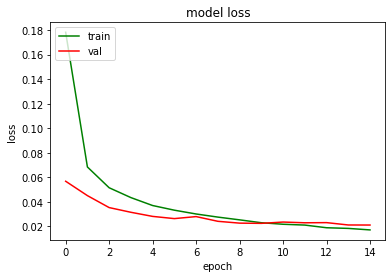

In [52]:
plt.plot(history.history['loss'], color="green")
plt.plot(history.history['val_loss'], color="red")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

As we can see, training further yielded no results.